In [ ]:
"""
Horseshoe Prior for Sparse Bayesian Regression

📌 **Objective**:
- Demonstrate how the horseshoe prior helps when most predictors are irrelevant (sparse signals), while providing uncertainty over which features matter.
- I'm the brand analyst for a frozen dessert company selling on a last-mile delivery app. We have weekly market level data for many potential drivers of sales. 
- Drivers: ad tactics, creative emphasis, promos & pricing, ops, seasonality/holidays, market context. 
- Goal: Only a few of these truly move the needle right now, identify which features matter and estimate their effects with uncertainty. 

🔍 **Key Takeaways**:
- **BLAH**: 

- **Next Steps**: 
    - 

📌 **Methodology**:
1. **blah**


✍ **Author**: Justin Wall
📅 **Date**: 09/03/2025
"""

'\nHorseshoe Prior for Sparse Bayesian Regression\n\n📌 **Objective**:\n- Demonstrate how the horseshoe prior helps when most predictors are irrelevant (sparse signals), while providing uncertainty over which features matter.\n\n🔍 **Key Takeaways**:\n- **BLAH**: \n\n- **Next Steps**: \n    - \n\n📌 **Methodology**:\n1. **Create a causal graph** using NetworkX\n2. **Perform causal discovery** using DoWhy\n\n\n✍ **Author**: Justin Wall\n📅 **Date**: 08/28/2025\n'

In [6]:
# ================================= #
# Import Libraries                  #
# ================================= #
#%%
# 1) Imports & basic config
import numpy as np
import pandas as pd
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
#%%

In [8]:
# ================================= #
# Create Synthetic Dataset          #
# ================================= #
#%%
rng = default_rng(42)

# 2) Panel skeleton: 6 markets x 50 weeks = 300 rows
markets = ["Portland","Minneapolis","Chicago","Philadelphia","Miami","Dallas"]
weeks = pd.date_range("2024-01-01", periods=50, freq="W-MON")

df = pd.MultiIndex.from_product([markets, weeks], names=["market","week_start"]).to_frame(index=False)
n = len(df)

# 3) Helper: make a correlated block given a latent factor
def make_block(n, rho=0.6, k=10):
    z = rng.normal(size=n)  # shared latent
    eps = rng.normal(scale=np.sqrt(1 - rho**2), size=(n, k))
    return (rho * z[:, None] + eps)

# 4) Feature name groups (60 total)
ad_names = [
    "ad_search","ad_sponsored","ad_display","ad_social_fb","ad_social_ig",
    "ad_social_tt","ad_email","ad_push","ad_affiliate","ad_video"
]
creative_names = [
    "creative_video_share","creative_static_share","creative_carousel_share","creative_long_copy",
    "creative_short_copy","creative_bright_color","creative_dark_theme","creative_direct_cta",
    "creative_soft_cta","creative_newness"
]
promo_names = [
    "discount_pct","price_index","loyalty_points","coupon_redemptions","promo_depth",
    "promo_days","bogo_flag","voucher_spend","bundle_count","promo_push"
]
ops_names = [
    "in_stock_pct","oos_rate","delivery_promise_mins","avg_rating","service_issues",
    "lead_time","shelf_space","store_coverage","assortment_size","new_skus"
]
season_names = [
    "sin_annual","cos_annual","temp_index","holiday_blackfriday","holiday_july4",
    "holiday_memorial","holiday_labor","holiday_thanksgiving","seasonality_peak","back_to_school"
]
market_names = [
    "market_income","market_density","competition_index","age_index","student_share",
    "tourism_index","sports_events","rain_index","snow_index","traffic_index"
]

feature_cols = ad_names + creative_names + promo_names + ops_names + season_names + market_names

# 5) Build correlated blocks (start with generic normals)
blocks = {
    "ad": make_block(n, rho=0.6, k=len(ad_names)),
    "creative": make_block(n, rho=0.6, k=len(creative_names)),
    "promo": make_block(n, rho=0.6, k=len(promo_names)),
    "ops": make_block(n, rho=0.6, k=len(ops_names)),
    "season": make_block(n, rho=0.6, k=len(season_names)),
    "market": make_block(n, rho=0.6, k=len(market_names)),
}

# 6) Fill DataFrame with transformed, story-friendly values

# Ads: positive-ish "spend" scales (lognormal-ish)
ad_raw = np.exp(blocks["ad"] * 0.6 + 1.6)  # keeps magnitudes reasonable
for j, name in enumerate(ad_names):
    df[name] = ad_raw[:, j]

# Creative: 0..1-ish emphasis proxies
cre_raw = 1 / (1 + np.exp(-blocks["creative"]))  # sigmoid
for j, name in enumerate(creative_names):
    df[name] = cre_raw[:, j]

# Promo/pricing: mix of bounded & positive
pr = blocks["promo"]
df["discount_pct"]       = np.clip(0.05 + 0.12 * (pr[:,0] / 2 + 0.5), 0, 0.5)
df["price_index"]        = 1.00 + 0.05 * pr[:,1]                     # >1 means we’re pricier than comps
df["loyalty_points"]     = np.clip(50 + 20 * (pr[:,2] + 1), 0, None)
df["coupon_redemptions"] = np.clip(100 + 40 * (pr[:,3] + 1.5), 0, None)
df["promo_depth"]        = np.clip(10 + 8 * (pr[:,4] + 1), 0, None)
df["promo_days"]         = np.clip((pr[:,5] + 2.5).round().astype(int), 0, 7)
df["bogo_flag"]          = (pr[:,6] > 0.8).astype(int)
df["voucher_spend"]      = np.clip(1000 + 300 * (pr[:,7] + 1.0), 0, None)
df["bundle_count"]       = np.clip((pr[:,8] + 2).round().astype(int), 0, None)
# Tie promo_push a bit to ad_push to reflect coordination
df["promo_push"]         = np.clip(0.3 * df["ad_push"] + 0.02 * rng.normal(size=n), 0, None)

# Ops: realistic ranges
op = blocks["ops"]
in_stock = np.clip(0.90 + 0.04 * op[:,0], 0, 1)
df["in_stock_pct"] = in_stock
df["oos_rate"] = np.clip(1 - in_stock + 0.02 * rng.normal(size=n), 0, 1)
df["delivery_promise_mins"] = np.clip(35 + 8 * op[:,2], 10, 120)
df["avg_rating"] = np.clip(4.4 + 0.2 * op[:,3], 1, 5)
df["service_issues"] = np.clip(2 + 1.2 * (op[:,4] + 1.0), 0, None)
df["lead_time"] = np.clip(1.5 + 0.4 * (op[:,5] + 1.0), 0.2, None)
df["shelf_space"] = np.clip(10 + 4 * (op[:,6] + 1.0), 1, None)
df["store_coverage"] = np.clip(0.6 + 0.2 * (op[:,7] / 2 + 0.5), 0, 1)
df["assortment_size"] = np.clip(15 + 6 * (op[:,8] + 1.0), 1, None)
df["new_skus"] = np.clip((op[:,9] + 2).round().astype(int), 0, None)

# Season/holiday: use real dates for dummies + sin/cos
t = (df["week_start"] - df["week_start"].min()).dt.days.values
sin_annual = np.sin(2 * np.pi * t / 365.25)
cos_annual = np.cos(2 * np.pi * t / 365.25)
df["sin_annual"] = sin_annual
df["cos_annual"] = cos_annual
df["temp_index"] = (sin_annual * 10) + 60 + rng.normal(scale=2.0, size=n)  # "temperature-like"

def week_has(d_series, target):
    # Mark 1 if week includes the specific calendar date (±3 days)
    delta = (d_series - target).abs()
    return (delta.dt.days <= 3).astype(int)

dates = df["week_start"]
df["holiday_blackfriday"]   = week_has(dates, pd.Timestamp("2024-11-29"))
df["holiday_july4"]         = week_has(dates, pd.Timestamp("2024-07-04"))
df["holiday_memorial"]      = week_has(dates, pd.Timestamp("2024-05-27"))
df["holiday_labor"]         = week_has(dates, pd.Timestamp("2024-09-02"))
df["holiday_thanksgiving"]  = week_has(dates, pd.Timestamp("2024-11-28"))
# extra seasonal knobs
df["seasonality_peak"] = (sin_annual > 0.8).astype(int)
df["back_to_school"]   = ((dates.dt.month >= 8) & (dates.dt.month <= 9)).astype(int)

# Market context: mostly static by market with small wiggle
mk = blocks["market"]
for j, name in enumerate(market_names):
    base = rng.normal(size=len(markets))
    # Assign base by market, then add small within-market variation
    df[name] = df["market"].map({m: base[i] for i, m in enumerate(markets)}).values + 0.1 * mk[:, j]


# 7) Define the *true* sparse signal (only 5 features matter)
true_signals = {
    "ad_search": 1.6,              # paid search is effective
    "ad_sponsored": 1.1,           # sponsored listings help
    "in_stock_pct": 1.4,           # availability drives sales
    "price_index": -1.2,           # being pricier hurts
    "holiday_blackfriday": 0.9,    # spike on Black Friday
}

# 8) Build standardized design matrix and generate target `sales`
X = df[feature_cols].to_numpy()
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

beta = np.zeros(X_std.shape[1])
name_to_idx = {name:i for i, name in enumerate(feature_cols)}
for k, v in true_signals.items():
    beta[name_to_idx[k]] = v

# latent "sales" (continuous) + noise; then shift/scale to nice numbers
noise = rng.normal(0, 1.0, size=n)
y_latent = X_std @ beta + noise
df["sales"] = (y_latent - y_latent.mean()) * 80 + 1200  # center ~1200 units

# 9) Quick peek
print("Shape:", df.shape)
print("Columns:", len(df.columns))
print("True signal features:", true_signals)
df.sample(5, random_state=0)
#%%

Shape: (300, 63)
Columns: 63
True signal features: {'ad_search': 1.6, 'ad_sponsored': 1.1, 'in_stock_pct': 1.4, 'price_index': -1.2, 'holiday_blackfriday': 0.9}


,market,week_start,ad_search,ad_sponsored,ad_display,ad_social_fb,ad_social_ig,ad_social_tt,ad_email,ad_push,...,market_density,competition_index,age_index,student_share,tourism_index,sports_events,rain_index,snow_index,traffic_index,sales
208,Miami,2024-02-26,3.166058,5.276319,1.729946,2.817073,5.013846,2.688825,1.668021,4.976723,...,0.357425,0.817609,0.055157,0.748688,0.939516,-0.150731,1.544917,0.106480,0.715304,979.234791
188,Philadelphia,2024-09-23,8.378019,3.387153,1.237966,1.870718,1.312615,3.051958,2.854784,2.417221,...,-0.270416,0.941032,1.751084,0.313811,-1.178515,1.284577,0.811507,-0.393411,-0.593323,1221.504362
12,Portland,2024-03-25,5.301511,3.393358,3.813162,2.492070,3.311717,4.271321,7.459526,11.585341,...,-0.005165,-0.868795,0.078132,-1.143295,0.362454,0.629413,1.268105,0.719957,-1.018806,996.193641
221,Miami,2024-05-27,4.049517,12.262518,5.995907,7.953734,5.735610,4.078672,5.433430,10.767970,...,0.553035,0.856888,0.040898,0.593556,0.676522,-0.293820,1.385989,0.180857,0.909976,1452.934114
239,Miami,2024-09-30,2.214980,2.494345,3.970962,3.434453,8.012375,6.472025,5.192072,4.389891,...,0.383962,0.741343,0.104943,0.783307,0.815541,-0.222960,1.551942,0.124131,0.798062,979.234617


In [ ]:
# ================================= #
# Understand Data                   #
# ================================= #
#%%
df.info()
#%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   market                   300 non-null    object        
 1   week_start               300 non-null    datetime64[ns]
 2   ad_search                300 non-null    float64       
 3   ad_sponsored             300 non-null    float64       
 4   ad_display               300 non-null    float64       
 5   ad_social_fb             300 non-null    float64       
 6   ad_social_ig             300 non-null    float64       
 7   ad_social_tt             300 non-null    float64       
 8   ad_email                 300 non-null    float64       
 9   ad_push                  300 non-null    float64       
 10  ad_affiliate             300 non-null    float64       
 11  ad_video                 300 non-null    float64       
 12  creative_video_share     300 non-nul

In [30]:
df['market'].nunique()

6

In [12]:
# ================================= #
# Baseline Model                    #
# ================================= #
#%%
# Holdout last 12 weeks as test dataset
df_sorted = df.sort_values(['week_start','market']).reset_index(drop=True)

unique_weeks = np.sort(df_sorted['week_start'].unique())
test_weeks = unique_weeks[-12:]
train_mask = ~df_sorted['week_start'].isin(test_weeks)
test_mask = ~train_mask

# Design Matrix & Target
X = df_sorted[feature_cols].to_numpy()
y = df_sorted['sales'].to_numpy()

scaler = StandardScaler().fit(X[train_mask])
X_train_s = scaler.transform(X[train_mask])
X_test_s = scaler.transform(X[test_mask])

y_train = y[train_mask]
y_test = y[test_mask]

print(f"X_train: {X_train_s.shape}, X_test: {X_test_s.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

# Alphas for Ridge, LassoCV wil choose it's own path if alphas=None
alphas = np.logspace(-3, 3, 61)

ols = LinearRegression().fit(X_train_s, y_train)
ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train_s, y_train)
lasso = LassoCV(alphas=alphas, cv=5, n_alphas=200).fit(X_train_s, y_train)

print(f"Ridge alpha_: {ridge.alpha_}")
print(f"Lasso alpha_: {lasso.alpha_}")

#%%

X_train: (228, 60), X_test: (72, 60), y_train: (228,), y_test: (72,)


c:\Users\justi\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14045.42799799412, tolerance: 1021.0394371531654
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\justi\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50448.59840665443, tolerance: 1021.0394371531654
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\justi\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82453.36773381324, tolerance: 1021.0394371531654
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\justi\miniforge3\envs\pymc_env\Lib\si

Ridge alpha_: 6.309573444801936
Lasso alpha_: 6.309573444801936


c:\Users\justi\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84782.81076565315, tolerance: 830.1477417778924
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\justi\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115280.44166208612, tolerance: 830.1477417778924
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\justi\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27195.689669715124, tolerance: 1003.2415656176057
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\justi\miniforge3\envs\pymc_env\Lib\si

In [31]:
# ================================= #
# Evaluate Model & Make Predictions #
# ================================= #
#%%
preds = {
    "OLS": ols.predict(X_test_s),
    "Ridge": ridge.predict(X_test_s),
    "Lasso": lasso.predict(X_test_s)
}
rmse = {name: np.sqrt(mean_squared_error(y_test, yhat)) for name, yhat in preds.items()}
rmse
#%%

{'OLS': 185.33658941952783,
 'Ridge': 183.00701849464315,
 'Lasso': 181.7205880833917}

In [18]:
# ================================= #
# Grab Coefficients                 #
# ================================= #
#%%

true_set = set(true_signals.keys())
k_true = len(true_signals)

def topk_support(beta, names, k):
    idx = np.argsort(np.abs(beta))[::-1][:k]
    return [names[i] for i in idx]

def thresh_support(beta, names, thresh=0.10):
    idx = np.where(np.abs(beta) >= thresh)[0]
    return [names[i] for i in idx]

def prf(pred_set, true_set):
    pred_set = set(pred_set)
    tp = len(pred_set & true_set)
    fp = len(pred_set - true_set)
    fn = len(true_set - pred_set)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0
    return {"TP": tp, "FP": fp, "FN": fn, "Precision": precision, "Recall": recall, "F1": f1}

def coef_series(beta, names):
    return pd.Series(beta, index=names).sort_values(key=lambda s: s.abs(), ascending=False)

# Grab coefficients (on standardized features)
coef_ols   = ols.coef_
coef_ridge = ridge.coef_
coef_lasso = lasso.coef_
#%%

In [20]:
# ================================= #
# Grab Coefficients                 #
# ================================= #
#%%

# Show the top-10 coefficients by absolute value for each model
top_ols   = coef_series(coef_ols, feature_cols).head(10)
top_ridge = coef_series(coef_ridge, feature_cols).head(10)
top_lasso = coef_series(coef_lasso, feature_cols).head(10)

print("True signals:", true_signals, "\n")

print("=== Top-10 OLS Coefs ===")
display(top_ols)

print("=== Top-10 Ridge Coefs ===")
display(top_ridge)

print("=== Top-10 Lasso Coefs ===")
display(top_lasso)

# Evaluate support recovery two ways:
# (1) Top-k (k = number of true signals), (2) Thresholding absolute coefficient
metrics = {}
for name, beta in [("OLS", coef_ols), ("Ridge", coef_ridge), ("Lasso", coef_lasso)]:
    pred_topk = topk_support(beta, feature_cols, k_true)
    pred_thr  = thresh_support(beta, feature_cols, thresh=0.10)

    metrics[name] = {
        "topk_support": pred_topk,
        "topk_metrics": prf(pred_topk, true_set),
        "thr_support":  pred_thr,
        "thr_metrics":  prf(pred_thr, true_set),
    }

metrics
#%%

True signals: {'ad_search': 1.6, 'ad_sponsored': 1.1, 'in_stock_pct': 1.4, 'price_index': -1.2, 'holiday_blackfriday': 0.9} 

=== Top-10 OLS Coefs ===


ad_push              140.317820
promo_push          -139.362257
ad_search            114.810089
in_stock_pct          97.357803
price_index          -91.233234
ad_sponsored          84.446873
competition_index    -83.243460
market_income         74.538002
student_share         70.038699
market_density       -42.559801
dtype: float64

=== Top-10 Ridge Coefs ===


ad_search             110.134867
in_stock_pct           90.270866
price_index           -87.485980
ad_sponsored           83.369890
competition_index     -18.637241
market_income          17.223045
oos_rate              -16.771798
coupon_redemptions    -16.173032
temp_index            -16.093916
tourism_index          15.731900
dtype: float64

=== Top-10 Lasso Coefs ===


ad_search                111.117864
in_stock_pct              99.960632
price_index              -87.199377
ad_sponsored              83.463963
coupon_redemptions        -8.241315
delivery_promise_mins      5.161320
market_density            -4.058557
ad_social_ig               2.325372
oos_rate                  -2.291659
promo_depth               -1.219166
dtype: float64

{'OLS': {'topk_support': ['ad_push',
   'promo_push',
   'ad_search',
   'in_stock_pct',
   'price_index'],
  'topk_metrics': {'TP': 3,
   'FP': 2,
   'FN': 2,
   'Precision': 0.6,
   'Recall': 0.6,
   'F1': 0.6},
  'thr_support': ['ad_search',
   'ad_sponsored',
   'ad_display',
   'ad_social_fb',
   'ad_social_ig',
   'ad_social_tt',
   'ad_email',
   'ad_push',
   'ad_affiliate',
   'ad_video',
   'creative_video_share',
   'creative_static_share',
   'creative_carousel_share',
   'creative_long_copy',
   'creative_short_copy',
   'creative_bright_color',
   'creative_dark_theme',
   'creative_direct_cta',
   'creative_soft_cta',
   'creative_newness',
   'discount_pct',
   'price_index',
   'loyalty_points',
   'coupon_redemptions',
   'promo_depth',
   'promo_days',
   'bogo_flag',
   'voucher_spend',
   'bundle_count',
   'promo_push',
   'in_stock_pct',
   'oos_rate',
   'delivery_promise_mins',
   'avg_rating',
   'service_issues',
   'lead_time',
   'shelf_space',
   'store_co

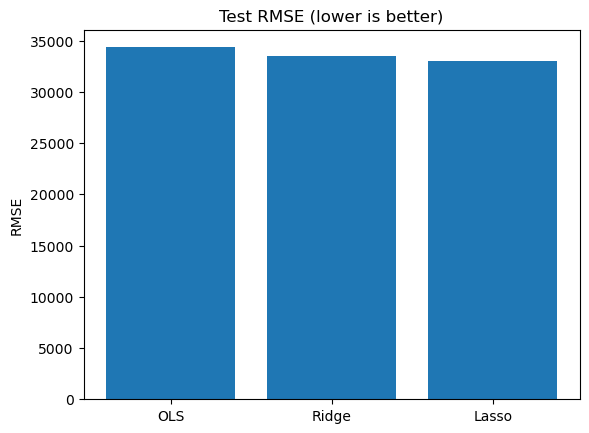

In [21]:
# ================================= #
# RMSE Bar Chart                    #
# ================================= #
#%%
names = list(rmse.keys())
vals  = [rmse[k] for k in names]

plt.figure()
plt.bar(names, vals)
plt.title("Test RMSE (lower is better)")
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.show()
#%%

In [32]:
# ================================= #
# RMSE Per Market                   #
# ================================= #
#%%
# Useful for MMM-style data
test_df = df_sorted.loc[test_mask, ["market"]].copy()
test_df["y_true"] = y_test
for name, pred in preds.items():
    test_df[f"yhat_{name}"] = pred

rmse_by_market = (
    test_df
    .groupby("market")
    .apply(lambda g: pd.Series({
        "RMSE_OLS":   np.sqrt(mean_squared_error(g["y_true"], g["yhat_OLS"])),
        "RMSE_Ridge": np.sqrt(mean_squared_error(g["y_true"], g["yhat_Ridge"])),
        "RMSE_Lasso": np.sqrt(mean_squared_error(g["y_true"], g["yhat_Lasso"])),
    }))
).sort_index()

rmse_by_market
#%%

C:\Users\justi\AppData\Local\Temp\ipykernel_28196\1701322982.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,RMSE_OLS,RMSE_Ridge,RMSE_Lasso
market,,,
Chicago,169.492070,169.659702,179.805357
Dallas,182.127413,177.056414,174.698962
Miami,191.234582,200.051316,207.996049
Minneapolis,170.673492,171.354749,175.415236
Philadelphia,243.836642,229.205466,207.904869
Portland,137.998325,137.469632,134.265569


In [33]:
# ================================= #
# PYMC Horseshoe Prior              #
# ================================= #
#%%
p = X_train_s.shape[1]
coords = {"feature": np.array(feature_cols)}

with pm.Model(coords=coords) as hs_model:
    # global + local shrinkage
    tau = pm.HalfCauchy("tau", beta=1.0)
    lam = pm.HalfCauchy("lam", beta=1.0, dims="feature")

    sigma = pm.HalfNormal("sigma", sigma=1.0)
    beta = pm.Normal("beta", mu=0.0, sigma=tau * lam, dims="feature")
    mu = pm.math.dot(X_train_s, beta)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    idata_hs = pm.sample(draws=1500, tune=1500, chains=2, target_accept=0.9, progressbar=True)
#%%

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, lam, sigma, beta]


Output()

Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 203 seconds.
There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [34]:
# ================================= #
# Posterior Predictions on test     #
# ================================= #
#%%

# posterior mean prediction
beta_draws = idata_hs.posterior["beta"].stack(draws=("chain", "draw")).values
beta_mean  = beta_draws.mean(axis=1)

yhat_hs_mean = X_test_s @ beta_mean
hs_rmse_mean = np.sqrt(mean_squared_error(y_test, yhat_hs_mean))

yhat_draws = X_test_s @ beta_draws
rmse_draws = np.sqrt(((yhat_draws - y_test[:, None])**2).mean(axis=0))
hs_rmse_summary = {
    "mean": float(rmse_draws.mean()),
    "p05": float(np.percentile(rmse_draws, 5)),
    "p50": float(np.percentile(rmse_draws, 50)),
    "p95": float(np.percentile(rmse_draws, 95)),
}

hs_rmse_mean, hs_rmse_summary

#%%

(1234.5249791593483,
 {'mean': 1234.8251726304402,
  'p05': 1220.1955425007277,
  'p50': 1234.987220264548,
  'p95': 1249.0163470968876})